In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# How to normalize spectrograms
> Scaling spectrograms for neural networks.  

- toc: true 
- badges: true
- comments: true
- categories: [normalizing_spectrums]
- image: images/violin_spec.png

# Introduction  

When training convolutional neural networks for audio tasks, spectrograms are often used as images. Treating spectrograms like images opens up a host of powerful techniques from deep learning image recognition. A spectrogram, however, is fundamentally different from natural images as we will see below. That raises the central question of this post: what is the proper way to normalize spectrograms for training neural networks?  

This post assumes some familiarity with deep learning terms and signal processing concepts like the FFT. Knowledge about the [`fastai`](https://github.com/fastai/fastai) library is not needed, but with some of the code.

# Turning audio into an image

It is hard to overstate the success of deep neural networks for classifying images. This challenging task was previously done with expert handcrafted features. Now, the features are automatically learned from labeled data instead. The performance of these learned features completely shifted the Computer Vision paradigm. We would ideally like to apply these same, proven approaches to audio tasks.

However, in most Machine Learning applications audio is processed as a one dimensional signal. Even stereo recordings with more than one channel are first mixed into mono (single channel) before processing. That means raw audio is unusable with 2D Convolutional networks, the workhorse of modern image classification. If we could represent audio in two dimensions, like an image, we could apply many great ideas from image recognition.

Thankfully there are many ways to transform audio into two dimensions. The most popular one is the short-time Fourier Transform [(STFT)](https://www.dsprelated.com/freebooks/sasp/Short_Time_Fourier_Transform.html). The STFT turns audio into a spectrogram: a 2-D signal representation in time and frequency. Since a spectrogram is two dimensional, we can treat it like an image!  

Before plugging spectrograms into a neural network we need a data pipeline. And data normalization is one of the first steps in any good data pipeline. This is because learning with unnormalized inputs is difficult and convergence could take a very long time.  
For natural images, normalization uses an estimated mean ($\mu$) and standard deviation ($\sigma$) as follows: 
- Subtract $\mu$ from the image values to give them a mean of $0$. 
- Divide the images by $\sigma$ to give them a variance of $1$. 

In math terms if $x$ is our image, then:  $$x_{\text{norm}} = \frac{(x - \mu)}{\sigma}$$

# Sample audio dataset


To keep things practical, we will apply these spectrogram normalization techniques to a [sound classification challenge](https://github.com/fastaudio/Audio-Competition) hosted by `fastaudio`. [`fastaudio`](https://github.com/fastaudio/fastaudio) is a community extension of the [`fastai`](https://github.com/fastai/fastai) library to make audio tasks with neural networks more accessible.  
The challenge here is to classify sounds in the [ESC-50 dataset](https://github.com/karolpiczak/ESC-50).
ESC-50 stands for "Environment Sound Classification with 50 classes". This dataset is quite diverse and gives a good feel for how different audio spectrograms can be.

Many of the lines below are based on the `fastaudio` [baseline results notebook](https://github.com/fastaudio/Audio-Competition/blob/master/ESC-50-baseline-1Fold.ipynb).

## Importing `fastai` and `fastaudio` modules

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

## Downloading the ESC-50 dataset

The first step is to download the dataset. ESC-50 is included in `fastaudio` so we grab it with fastai's `untar_data`.

In [3]:
# already in fastaudio, can download with fastai's `untar_data`
path = untar_data(URLs.ESC50)

Looking inside of the downloaded `audio` folder reveals many `.wav` files.  
Note that we check the folder with the `ls` method, a handy fastai addition to python's standard `pathlib.Path` that mimics the linux command.

In [4]:
wavs = (path/"audio").ls()
wavs

(#2000) [Path('/home/titan2/2A/cck/fastai/data/master/audio/3-68630-A-40.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/5-260433-A-39.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/5-188796-A-45.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/1-57318-A-13.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/4-141365-A-18.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/1-9886-A-49.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/3-71964-C-4.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/5-201172-A-46.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/3-253084-E-2.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/1-91359-A-11.wav')...]

The output of `ls` shows 2,000 audio files. But the filenames are not that descriptive, so how can we know what is actually in each one?  
Thankfully, as with many datasets, the download includes a table with more information about the data (aka metadata).

In [5]:
# read the audio metadata and show the first few rows
df = pd.read_csv(path/"meta"/"esc50.csv")
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


The key info from the table are the `filename` and `category` columns.  
`filename` gives the name of the file inside of the `audio` folder.  
`category` tells us which class it belongs to.

We pick the last file in the data directory as a working example. The file's `name` can index into the metadata table above to show more information.

In [6]:
# pick the row where "filename" matches the file's "name".
df.loc[df.filename == wavs[-1].name]

,filename,fold,target,category,esc10,src_file,take
1826,5-216213-A-13.wav,5,13,crickets,False,216213,A


This is a recording of crickets!  
To load this recording, we use the `AudioTensor` class in `fastai` to read the audio into a `torch.Tensor`. The `create` function directly loads from an audio file.

In [7]:
# create an AudioTensor from a file path
sample = AudioTensor.create(wavs[-1])

An `AudioTensor` can directly plot and even play a sample with its `show` method. Each "burst" in the file is a cricket chirp. There are three full chirps and the early starts of a fourth chirp.

<AxesSubplot:>

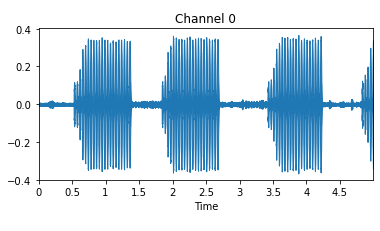

In [8]:
sample.show()

# Normalizing waveforms

The first step is normalizing the audio waveform itself. We give it a mean of zero and unit variance in the typical way: 

$$\text{norm_audio} = \frac{\text{audio} - mean(\text{audio})}{std(\text{audio})} $$

In [9]:
# normalize the waveform
norm_sample = (sample - sample.mean()) / sample.std()

Let's check if the mean is roughly $0$ and the variance is roughly $1$:

In [10]:
# checking if normalization worked
norm_sample.mean(),norm_sample.var()

(AudioTensor(2.8762e-10), AudioTensor(1.))

Success! The waveform is normalized.

We make a small `Transform` to normalize each waveform for later use.

In [11]:
class AudioNormalize(Transform):
    "Normalizes a single `AudioTensor`."
    def encodes(self, x:AudioTensor): return (x-x.mean()) / x.std()

In [12]:
# checking if the Transform normalizes a waveform
wav_norm = AudioNormalize()
norm_sample = wav_norm(sample)
norm_sample.mean(),norm_sample.var()

(AudioTensor(2.8762e-10), AudioTensor(1.))

# Extracting spectrograms from audio

We are now ready to extract a spectrogram from the normalized audio. The `fastaudio` library uses a class named `AudioToSpec` that wraps parts of [`torchaudio`](https://pytorch.org/audio/) to convert an `AudioTensor` into a spectrogram.

In [13]:
# create a fastaudio Transform that converts audio into spectrograms
cfg = AudioConfig.BasicSpectrogram() # defaults from torchaudio
audio2spec = AudioToSpec.from_cfg(cfg)

The spectrogram computation details are not important here. But a quick look at the [spectrogram source code](https://pytorch.org/audio/_modules/torchaudio/functional.html#spectrogram) shows that it boils down to some pre and post processing around a [torch.stft](https://pytorch.org/docs/stable/generated/torch.stft.html) call. We now transform the audio into a spectrogram.

In [14]:
# extract the spectrogram
spec = audio2spec(norm_sample)

Just like with waveforms, `fastaudio` can directly plot spectrograms. The colorbar on the right is especially helpful here, since `matplotlib` always normalizes the values in a plot to a certain color range. Withtout the colorbar, the fixed color range makes it impossible to know or even guess the exact values in a spectrogram plot.

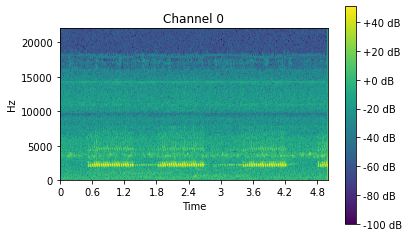

In [15]:
spec.show();

This is a good time to compare the shapes of the audio and spectrogram to see the new, added dimension that turned the spectrogram into an "image".

In [16]:
print(f'Audio shape [channels, samples]: {norm_sample.shape}')
print(f'Spectrum shape [channels, bins, time_steps]: {spec.shape}')

Audio shape [channels, samples]: torch.Size([1, 220500])
Spectrum shape [channels, bins, time_steps]: torch.Size([1, 201, 1103])


# How do we normalize spectrograms?

As stated in the introduction, a spectrogram is fundamentally different from an image.

Both dimensions in an image are in the spatial domain and have the same units.
Images are stored as integers in the range of `[0, 255]`.  
To normalize first divide all pixels by 255, the max possible value, to map them into `[0, 1]`.  
Then, find the statistics that approximately center the data and give it unit variance.  
For a color image we have three channels (RGB) and normalize each one.
If the image is grayscale then we normalize its single channel instead.
Given the layout of natural images, and the fact that both dimensions are in the same domain, it makes sense to normalize each channel with single, global values.

Spectrograms are different.
In a spectrogram, one dimension represents time and the other represents frequency.
Different quantities, scales, and sizes.
Frequency dimension given by choice of FFT size. Sets our spectral resolution.
Time dimension given by length of our signal, FFT size, and window overlap. Sets our temporal resolution.
In fact what we call the spectrogram is actually the log of the power spectrum.
Below we give a quick recap of how the spectrogram is computed to show how it differs from images.

If $\text{x}$ is the input audio then the STFT returns the spectrum:
$$\text{spectrum} = \text{STFT(x)}$$
We are more interested in the energy or power of the signal, so we take the absolute value of the STFT and square it:  
$$\text{power_spectrum} = |\text{STFT(x)}|^2$$ 
While we could use the power spectrum as our input "image", it is a bit problematic. The power spectrum often has a few, strong peaks and many small values. This means the values are [heavy-tailed](https://danielsdiscoveries.wordpress.com/2017/09/29/spectrogram-input-normalisation-for-neural-networks/) and make for poor network inputs.  
To deal with this we take the log of the power spectrum which spreads out the values. This becomes the spectrogram:
$$\text{spectrogram} = log(|\text{STFT(x)}|^2)$$
The range of the log function is from $-\infty$ to $+\infty$ which is very different than the integers from 0 to 255.


However, the spectrogram also introduces the notion of a different type of channel.
This makes "channel" an overloaded term for our purposes but it is still a crucial piece of the puzzle. 
The spectrogram transform can be interpreted as a "channelizer".
That is a fancy way to say that it takes the continuous frequency spectrum of our signal and chops it up into discrete bins, or channels. For example, consider a signal sampled at 16 kHz (typical for audio) where we take an STFT of size 512. Our spectrogram will have 512 channels where each one has a "bandwidth" of $$16 \ \text{kHz} \ \ / \ \ 512 \ \text{bins} = 31.25 \ \text{Hz per bin}$$

Even though these spectrum channels are different from the channels in an image, it raises the question: should we (or can we?) normalize an entire spectrum "image" with a single, global value? Or do we need to normalize each channel, as is done with images?  

There is no clear answer here, and your approach will likely depend both on the specifics of your problem and where your system will be deployed.
For example, if your are building a system that will be deployed in a similar environment as the training one, then it might make more sense to normalize by channels.
Your channel-based normalization statistics will follow the average noise floor and activity of the training data.
This motivation hold if you expect roughly the same patterns and distributions of activity once the system is deployed.
However, it will be critical to monitor the deployed environment and update the statistics as needed, else you slowly shift out of domain.

If your system will instead be used in a completely different environment, of which you have no knowledge, then the global statistics could be a better fit. While not as technically sound, your model won't be as surprised by radically new activity across different channels. 

Lastly, we also have issue of Transfer Learning. In Transfer Learning it is best-practice to normalize the new dataset with the statistics from the old dataset. In most cases that means normalizing with ImageNet statistics.
So if you are doing transfer learning, the easiest approach will be to use original stats. 
If your dataset is large enough that you are training from scratch, then the above applies.

# Spectrogram Normalization

First we step through the training set once to get the mean and standard deviation of each mini-batch. Note that normalization statistics must always come from the training set, this is a crucial place to avoid data leakage from the validation set. Then, we average the statistics from each mini-batch to get a pair of "global" statistics.  
One small detail: if your training dataset is large enough, you often do not need to iterate through the whole set. Sampling 10% to 20% of the dataset can be enough for accurate statistics. However, since ESC-50 is small we get statistics from the whole set. 

First we need to accumulate these statistics over mini-batches. To accomplish this we can borrow and slightly refactor a class from this [incredibly helpful post](http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html). The `StatsRecorder` class below tracks the mean and standard deviation across mini-batches.

In [17]:
class StatsRecorder:
    def __init__(self, red_dims=(0,2,3)):
        """Accumulates normalization statistics across mini-batches.
        ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """
        self.red_dims = red_dims # which mini-batch dimensions to average over
        self.nobservations = 0   # running number of observations

    def update(self, data):
        """
        data: ndarray, shape (nobservations, ndimensions)
        """
        # initialize stats and dimensions on first batch
        if self.nobservations == 0:
            self.mean = data.mean(dim=self.red_dims, keepdim=True)
            self.std  = data.std (dim=self.red_dims,keepdim=True)
            self.nobservations = data.shape[0]
            self.ndimensions   = data.shape[1]
        else:
            if data.shape[1] != self.ndimensions:
                raise ValueError('Data dims do not match previous observations.')
            
            # find mean of new mini batch
            newmean = data.mean(dim=self.red_dims, keepdim=True)
            newstd  = data.std(dim=self.red_dims, keepdim=True)
            
            # update number of observations
            m = self.nobservations * 1.0
            n = data.shape[0]

            # update running statistics
            tmp = self.mean
            self.mean = m/(m+n)*tmp + n/(m+n)*newmean
            self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
                        m*n/(m+n)**2 * (tmp - newmean)**2
            self.std  = torch.sqrt(self.std)
                                 
            # update total number of seen samples
            self.nobservations += n

By default `StatsRecorder` averages over the image channel dimensions (grayscale or RGB). The `red_dims` argument might look familiar from normalization code in other Computer Vision tasks (even the `Normalize` in `fastai`).  
To average over spectrogram channels instead we pass a different `red_dims`. 

## Building the dataset loader

The setup belows follows the `fastaudio` ESC-50 baseline to iterate through the training dataset.  
One thing to mention is that by default, `fastaudio` resamples audio to 16 kHz. While much of the audio in the wild is sampled at 16 kHz, ESC-50 is actually sampled at a higher 44.1 kHz rate. Downsampling risks throwing away some information. But, keeping the higher sampling rate almost triples the "width" of the spectrogram. This much larger image potentially limits our batch size and architecture choices. For now we stick with downsampling to 16 kHz since it yields a very reasonable spectrogram shape of [201, 401].

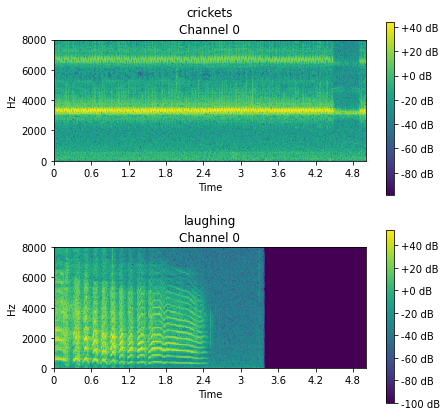

In [18]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

# do not resample audio
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_x=ColReader("filename", pref=path/"audio"), 
                 splitter=CrossValidationSplitter(fold=1),
                 item_tfms = [AudioNormalize],
                 batch_tfms = [audio2spec],
                 get_y=ColReader("category"))
dbunch = auds.dataloaders(df, bs=64)
dbunch.show_batch(figsize=(7,7))

## Finding spectrogram normalization statistics

Below we make two statistic recorders: one for global statistics and one for channel-based statistics. Then we step through the entire dataset and find the normalization stats.

In [19]:
# create recorders
global_stats  = StatsRecorder()
channel_stats = StatsRecorder(red_dims=(0,1,3))

# step through the dataset
with torch.no_grad():
    for idx,(x,y) in enumerate(iter(dbunch.train)):
        # update normalization statistics
        global_stats.update(x)
        channel_stats.update(x)
    
# parse out each set of stats
global_mean,global_std = global_stats.mean,global_stats.std
channel_mean,channel_std = channel_stats.mean,channel_stats.std

We can check the shape of both statistics to make sure they are as expected. For the global "grayscale" statistics, we expect a shape of: `[1,1,1,1]`. With spectrogram channel normalizations, we expect a shape of `[1,1,201,1]` with one normalization stat for each spectrogram bin.

In [20]:
print('Shapes of global mean/std:')
global_mean.shape,global_std.shape 

Shapes of global mean/std:


(torch.Size([1, 1, 1, 1]), torch.Size([1, 1, 1, 1]))

In [21]:
print('Shapes of channel mean/std:')
channel_mean.shape,channel_mean.shape 

Shapes of channel mean/std:


(torch.Size([1, 1, 201, 1]), torch.Size([1, 1, 201, 1]))

# Using the normalization statistics with `Transforms`

To use these normalization statistics in the training loop we need to extend the `Normalize` in `fastai`. The reason is type dispatch. `fastai` normalization uses ImageNet statistics due to the focus on transfer learning with color images. But this ImageNet normalization is only defined for RGB images of the `TensorImage` class. `AudioSpectrogram` subclasses the different `TensorImageBase`. The solution is to define `encodes` and `decodes` for `TensorImageBase` instead.

In [22]:
class SpecNormalize(Normalize):
    "Normalize/denorm batch of `TensorImage`"
    def encodes(self, x:TensorImageBase): return (x-self.mean) / self.std
    def decodes(self, x:TensorImageBase):
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std) + f(self.mean))

In [23]:
# make global and channel normalizers
GlobalSpecNorm  = SpecNormalize(global_mean,  global_std,  axes=(0,2,3))
ChannelSpecNorm = SpecNormalize(channel_mean, channel_std, axes=(0,1,3))

# Training with different normalizations

Now for the moment of truth. We train with the two different spectrogram normalizations and measure their impact. For this we again follow the `fastaudio` baseline and train each type of normalization for 20 epochs. The final score is the averaged accuracy of five runs.

In [24]:
epochs = 20
num_runs = 5

## Finding a good learning rate.

The learning rate is arguably the most critical neural network hyperparameter. `fastai` has a great empirical way to set a good learning rate with the `lr_find` function. The default learning rate in a `cnn_learner` ($\text{lr} = 0.001$) is often a good starting point. But since our task is so different from natural images it is worth re-evaluating this assumption.

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0030199517495930195)

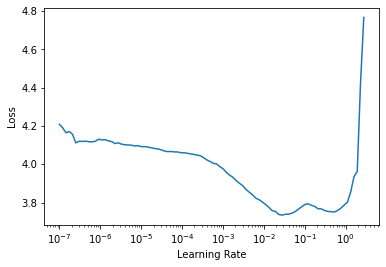

In [25]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_x=ColReader("filename", pref=path/"audio"), 
                 splitter=CrossValidationSplitter(fold=1), 
                 item_tfms = [AudioNormalize], 
                 batch_tfms = [audio2spec, GlobalSpecNorm],
                 get_y=ColReader("category"))
dls = auds.dataloaders(df, bs=64)

def make_xresnet_grayscale(model, n_in=1):
    "Modifies xresnet `model` for single channel images." 
    model[0][0].in_channels = n_in
    # sum weights to reduce dimension
    model[0][0].weight = torch.nn.parameter.Parameter(model[0][0].weight.sum(1, keepdim=True))

# make new grayscale xresnet with 50 outputs classes
model = xresnet18(pretrained=False, n_out=50)
make_xresnet_grayscale(model, n_in=1)

# wrap dataloaders and model into learner and find lr
learn = Learner(dls, model, metrics=[accuracy])
learn.lr_find()

It seems we can make the learning rate higher than the default. $0.002$ looks like a good point in the curve. It is close to the steepest learning rate, but still an order of magnitude higher than where the loss plateaus.

In [26]:
good_lr = 2e-3 # from `find_lr`

## Training helpers  

To avoid repeating ourselves, the helper functions below will build dataloaders and run the training loops.  
The `get_dls` function makes it clear which normalization is being applied. The `train_loops` function repeats training runs a given number of times.

In [27]:
def get_dls(bs=64, item_tfms=[], batch_tfms=[]):
    "Get dataloaders with given `bs` and batch/item tfms."
    auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                     get_x=ColReader("filename", pref=path/"audio"), 
                     splitter=CrossValidationSplitter(fold=1),
                     item_tfms=item_tfms,   # for waveform normalization
                     batch_tfms=batch_tfms, # for spectrogram normalization
                     get_y=ColReader("category"))
    dls = auds.dataloaders(df, bs=bs)
    return dls

def train_loops(dls, name, num_runs=num_runs, epochs=epochs):
    "Runs `num_runs` training loops with `dls` for given `epochs`."
    accuracies = []
    for i in range(num_runs):
        # make new grayscale xresnet
        model = xresnet18(pretrained=False, n_out=50)
        make_xresnet_grayscale(model, n_in=1)
        # get learner for this run
        learn = Learner(dls, model, metrics=[accuracy])
        # train network and track accuracy
        learn.fit_one_cycle(epochs, good_lr)
        accuracies.append(learn.recorder.values[-1][-1])
    print(f'Average accuracy for "{name}": {sum(accuracies) / num_runs}')

## Baseline performance  

Before getting carried away with normalization, we have to first know where we stand. This means setting a baseline without normalizations. That allows us to evaluate the impact of normalization later on, else there is no way to know if normalization helped at all.

In [28]:
# data without normalization
dls = get_dls(batch_tfms=[audio2spec])
# run training loops
train_loops(dls, name='No Norm')

epoch,train_loss,valid_loss,accuracy,time
0,3.864038,3.640563,0.047500,00:10
1,3.567385,3.270752,0.122500,00:10
2,3.275309,3.046638,0.160000,00:10
3,2.979019,2.988895,0.217500,00:10
4,2.681411,2.477376,0.297500,00:11
5,2.420927,2.551603,0.297500,00:10
6,2.148547,2.240297,0.375000,00:10
7,1.892246,2.298905,0.400000,00:10
8,1.639179,1.951818,0.475000,00:10
9,1.393503,1.676577,0.522500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.944712,3.667495,0.062500,00:10
1,3.611553,3.307175,0.162500,00:10
2,3.308181,3.225061,0.172500,00:10
3,3.012556,3.804607,0.132500,00:10
4,2.717575,3.020499,0.240000,00:10
5,2.423552,2.510827,0.330000,00:10
6,2.161031,2.640669,0.292500,00:10
7,1.872294,1.978955,0.462500,00:10
8,1.608560,1.767530,0.445000,00:11
9,1.373097,1.691516,0.522500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.815601,3.620078,0.077500,00:10
1,3.508639,3.168879,0.150000,00:11
2,3.163102,2.998596,0.160000,00:11
3,2.854859,3.164688,0.185000,00:11
4,2.557728,2.713461,0.270000,00:11
5,2.262357,2.944052,0.290000,00:10
6,1.977711,2.322385,0.365000,00:10
7,1.729180,1.872601,0.477500,00:11
8,1.485744,1.793844,0.500000,00:10
9,1.283887,1.519693,0.557500,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.877613,3.663718,0.060000,00:11
1,3.560435,3.308327,0.142500,00:11
2,3.221353,3.091815,0.170000,00:11
3,2.911155,3.346353,0.222500,00:11
4,2.621423,2.652071,0.252500,00:11
5,2.328344,2.337103,0.307500,00:11
6,2.033610,2.375937,0.360000,00:10
7,1.759097,2.004913,0.442500,00:11
8,1.497183,2.655351,0.422500,00:10
9,1.269249,1.907062,0.507500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.860989,3.604507,0.087500,00:11
1,3.525926,3.198408,0.190000,00:11
2,3.189915,2.885514,0.225000,00:11
3,2.864105,3.141410,0.195000,00:11
4,2.577845,2.606251,0.272500,00:11
5,2.308317,2.410204,0.335000,00:12
6,2.049876,2.382476,0.340000,00:11
7,1.790995,1.782477,0.470000,00:11
8,1.552726,1.790199,0.482500,00:11
9,1.325181,2.045983,0.445000,00:11


Average accuracy for "No Norm": 0.759499990940094


## Performance with global statistics 
Next we normalize each audio waveform and the spectrograms with global scalar statistics. 

In [29]:
# data with waveform and global normalization
dls = get_dls(item_tfms=[AudioNormalize],
              batch_tfms=[audio2spec, GlobalSpecNorm])
# run training loops
train_loops(dls, name='Global Norm')

epoch,train_loss,valid_loss,accuracy,time
0,3.899487,3.716551,0.065000,00:11
1,3.580346,3.249495,0.162500,00:11
2,3.229840,3.062807,0.167500,00:10
3,2.874923,2.886225,0.210000,00:10
4,2.537648,2.983616,0.255000,00:11
5,2.193204,2.408050,0.387500,00:11
6,1.873192,3.901555,0.247500,00:11
7,1.583586,2.110094,0.417500,00:10
8,1.332930,2.272940,0.422500,00:10
9,1.115968,1.788574,0.505000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.922318,3.739439,0.050000,00:10
1,3.609133,3.260656,0.132500,00:11
2,3.289700,3.011778,0.187500,00:11
3,2.943728,2.660806,0.285000,00:11
4,2.587499,2.784925,0.290000,00:11
5,2.249017,4.086281,0.202500,00:11
6,1.937279,2.083955,0.437500,00:11
7,1.659767,2.104303,0.405000,00:11
8,1.416648,1.890240,0.490000,00:11
9,1.173973,1.411902,0.602500,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.860879,3.663477,0.075000,00:11
1,3.569916,3.222121,0.150000,00:12
2,3.249906,2.998640,0.167500,00:12
3,2.937317,3.165269,0.205000,00:11
4,2.609325,2.747994,0.242500,00:12
5,2.269463,3.755162,0.255000,00:11
6,1.992285,2.747339,0.382500,00:11
7,1.716287,1.743193,0.487500,00:11
8,1.444023,1.466812,0.592500,00:12
9,1.217794,1.573326,0.570000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,3.900665,3.786899,0.045000,00:11
1,3.611424,3.318006,0.130000,00:10
2,3.289114,2.918618,0.255000,00:11
3,2.936364,3.061506,0.222500,00:11
4,2.594874,2.885726,0.227500,00:11
5,2.254868,2.391164,0.322500,00:11
6,1.979747,2.592324,0.345000,00:11
7,1.704618,2.341411,0.350000,00:11
8,1.440922,1.926113,0.467500,00:11
9,1.190519,1.436405,0.600000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.870293,3.685600,0.052500,00:10
1,3.575155,3.308343,0.135000,00:11
2,3.252811,3.063807,0.155000,00:11
3,2.928179,3.117989,0.207500,00:11
4,2.611506,2.522546,0.282500,00:11
5,2.290413,3.276541,0.267500,00:11
6,1.981827,2.704849,0.352500,00:11
7,1.696904,1.901445,0.510000,00:10
8,1.437622,1.640798,0.587500,00:10
9,1.198236,1.870519,0.507500,00:10


Average accuracy for "Global Norm": 0.7639999866485596


## Performance with channel statistics  
Finally, we normalize each audio waveform and the spectrograms with channel-based statistics.  

In [30]:
# get data with waveform and channel normalization
dls = get_dls(item_tfms=[AudioNormalize],
              batch_tfms=[audio2spec, ChannelSpecNorm])
# run training loops
train_loops(dls, name='Channel Norm')

epoch,train_loss,valid_loss,accuracy,time
0,3.814070,3.701240,0.052500,00:11
1,3.524528,3.227221,0.152500,00:11
2,3.214780,3.008464,0.170000,00:11
3,2.871844,3.041986,0.237500,00:11
4,2.546657,2.901429,0.227500,00:11
5,2.230851,2.085802,0.415000,00:11
6,1.944688,1.985253,0.440000,00:11
7,1.675866,1.714660,0.532500,00:11
8,1.448378,1.811781,0.520000,00:11
9,1.230421,1.697572,0.547500,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.829540,3.662957,0.057500,00:10
1,3.523394,3.247078,0.125000,00:11
2,3.195070,2.911327,0.217500,00:11
3,2.870339,3.128151,0.232500,00:10
4,2.562063,2.743944,0.270000,00:11
5,2.253818,2.408716,0.300000,00:10
6,1.958746,2.138429,0.400000,00:11
7,1.694537,1.966365,0.445000,00:11
8,1.457909,1.615925,0.577500,00:11
9,1.243191,1.447422,0.575000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.900508,3.695073,0.047500,00:11
1,3.583832,3.333769,0.112500,00:10
2,3.276954,2.971855,0.227500,00:10
3,2.955330,2.899534,0.232500,00:10
4,2.628291,2.334146,0.337500,00:10
5,2.311340,2.206679,0.390000,00:11
6,2.050411,2.226075,0.385000,00:11
7,1.759730,1.816403,0.512500,00:11
8,1.503236,2.032677,0.457500,00:11
9,1.261925,1.565456,0.520000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.935997,3.740494,0.057500,00:11
1,3.580015,3.233608,0.127500,00:11
2,3.238064,2.953737,0.210000,00:11
3,2.897370,2.816415,0.190000,00:11
4,2.616672,3.204674,0.207500,00:11
5,2.324050,2.603795,0.330000,00:11
6,2.043524,2.227057,0.355000,00:11
7,1.776979,2.359799,0.390000,00:11
8,1.545361,1.820567,0.527500,00:10
9,1.306066,2.344692,0.470000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.829459,3.706947,0.072500,00:11
1,3.520154,3.233519,0.115000,00:11
2,3.236644,3.153614,0.145000,00:11
3,2.958903,2.863204,0.227500,00:11
4,2.652667,2.681392,0.270000,00:11
5,2.370360,2.238871,0.347500,00:11
6,2.078221,2.507791,0.347500,00:11
7,1.814153,2.483367,0.370000,00:11
8,1.575667,1.748454,0.470000,00:11
9,1.359907,1.612051,0.557500,00:11


Average accuracy for "Channel Norm": 0.7480000019073486


# Discussion

I ran the cells above several times to make sure the patterns held. 

Overall, there is a small gain from global normalization. Channel-based normalization sometimes helps and sometimes hurts. While the increase in performance is small, there are several explanations for this that point us to other approaches.  

For starters, the spectrograms in ESC-50 are very different both within and across classes. That is to say there is wildly different activity in the spectrogram channels of each sample. A global statistic likely fares better under these conditions. If the audio all came from a similar source, say speech, then the per-channel normalization might fare better.  

We also process the entire five second spectrogram at once. This is a large analysis window by audio standards. Many systems operate at the "frame" level instead where fewer time steps are used for each sample. This large window also means we only see each example once during training, and it looks exactly the same at every epoch. If we used a smaller analysis window, say 2 seconds, we could randomly "crop" many spectrogram regions from a single example as a kind of data augmentation. The risk here is grabbing a silence region without any information but still giving it a class label (though thresholding can help here). Cropping with a smaller analysis window is one way to expose the models to more samples and variability. 

Using the entire waveform at once also means we are asking our waveform statistics to model a very long-term relationship. Going back to the cricket recording example: we would not expect good normalization statistics for the chirp region to be the same as good statistics for the pauses in between chirps. To counter this, it is possible to do a "short time" normalization. That is where we pick a sliding window, often much smaller than the whole waveform, and only normalize the data inside of it. This "short time" normalization can be applied with or without global waveform normalization. 

Furthermore, the spectrogram is a relatively high dimensional feature (201 frequency bins). It is very common in audio tasks to reduce this feature by grouping certain nearby, related bins. This is done with something called "filterbanks" which usually operate at the Mel frequency scale. [This tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) is one of my favorites and gives an incredibly clear description of Mel frequency and the filterbank process. There are other options such as [Gammatone filterbanks](https://www.mathworks.com/help/audio/ref/gammatonefilterbank-system-object.html) as well. While this might seem like an expert handcrafted feature, there is good reason for using it in audio tasks. If we feed in a raw spectrogram, the early convolutional layers in a network tend to learn something like a filterbank anyway! So we might as well help the networks by feeding in an acoustically-motivated filterbank, and let them focus on more complicated relationships. 

We are also training a powerful 18-layer model from scratch with only 1600 training images. Deep learning can handle these small datasets but only through Transfer Learning. We stayed away from Transfer Learning here because pre-trained networks are coupled to their original dataset's normalization statistics. And the main idea here was to learn our own scaling. It is very possible that a smaller, simpler network will perform better. But, if we look at the training logs above, the validation loss was still mostly decreasing. So we'd have to train for longer to check if the network is actually overfitting. The much lower training loss is nudging us in that direction, but is by no means conclusive.  

Lastly, we are not doing any data augmentation even though it is almost de-facto when training CNNs. This is another rabbit hole we could go down. Using image augmentations (flips, rotations, etc) do not make technical sense for a spectrogram. A better avenue would be spectrogram-specific like `[SpecAugment]`(https://arxiv.org/abs/1904.08779). By the way, `[SpecAugment]` already included in `fastaudio`!  Along with many other waveform and spectrogram augmentations. 

To recap, there are many good explanations for why our normalization only helped a little on the ESC-50 dataset. The points above describe a few of the many avenues to better increase performance.


# Conclusions

In this post we explored how to normalize spectrograms when training neural networks. We saw how spectrograms are fundamentally different than natural images and how there are at least two ways of normalizing them. 

Next we implemented these two normalization techniques and tested them against a baseline on the ESC-50 dataset for a small gain. We discussed why the gain was potentially so small, and some open avenues to further boost performance.

However, at the end of the day, there is no single theoretically correct way to normalize spectrograms as images for deep neural networks. Like many aspects of this field, the final choice will be experimental and depend on  the specifics of both the domain and task.  

I hope this post gave you a good notion for how to normalize spectrograms. I also hope it gave you some ideas, and potential approaches to try yourself! The ESC-50 challenge is a great playground for any new ideas.

# For fun, going as high as we can based on ImageNette

In [31]:
# from fastai.basics import *
# from fastai.vision.all import *
# from fastai.callback.all import *
# from fastai.distributed import *
# from fastprogress import fastprogress
# from torchvision.models import *
# from fastai.vision.models.xresnet import *
# from fastai.callback.mixup import *
# from fastscript import *

# auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
#                  get_x=ColReader("filename", pref=path/"audio"), 
#                  splitter=CrossValidationSplitter(fold=1),
#                  item_tfms = [AudioNormalize], 
#                  batch_tfms = [audio2spec, GlobalSpecNorm],
#                  get_y=ColReader("category"))
# dbunch = auds.dataloaders(df, bs=64)

# # with mixup, train for longer
# epochs = 80

# # ranger optimizer 
# lr      = 2e-3
# mom     = 0.9
# sqrmom  = 0.99
# eps     = 1e-6
# beta    = 0
# opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

# # default pooling
# pool = AvgPool

# # mish activation
# act_fn = Mish

# # loss function
# loss_func = LabelSmoothingCrossEntropyFlat()

# # with mixup augmentation
# mixup = True
# alpha = 0.4
# cbs = MixUp(alpha) if mixup else []

# # whether to use self-attention
# sa  = False
# sym = False

# # weight decay
# wd = 1e-2

# # the context manager way of dp/ddp, both can handle single GPU base case.
# gpu = 0
# n_gpu = torch.cuda.device_count()
# # ctx = learn.parallel_ctx if gpu is None and n_gpu else learn.distrib_ctx
# # ctx = learn.distrib_ctx

# # # model
# # n_out = 50
# # m = xse_resnext18
# # model = m(n_out=n_out, c_in=1, act_cls=act_fn, sa=sa, sym=sym, pool=pool)

# accuracies = []
# for run in range(num_runs):
#     print(f'Run: {run}')
# #     learn = Learner(dbunch, , opt_func=opt_func, \
# #             metrics=[accuracy], loss_func=loss_func)
#     learn = cnn_learner(dbunch, 
#                         xse_resnext18,
#                         pretrained=False,
#                         config=cnn_config(n_in=1),
#                         loss_fn=CrossEntropyLossFlat,
#                         opt_func=opt_func,
#                         metrics=[accuracy])
#     ctx = learn.parallel_ctx if gpu is None and n_gpu else learn.distrib_ctx
#     with partial(ctx, gpu)(): # distributed traing requires "-m fastai.launch"
#         print(f"Training in {ctx.__name__} context on GPU {gpu if gpu is not None else list(range(n_gpu))}")
#         learn.fit_flat_cos(epochs, lr, wd=wd, cbs=cbs)
# #         learn.fine_tune(epochs, lr, wd=wd, cbs=cbs)
#     accuracies.append(learn.recorder.values[-1][-1])

# print(f'Average accuracy for ImageNet training: {sum(accuracies) / num_runs}')